# Obtain Statistical Results

In [2]:
import pandas as pd
from geopy.geocoders import Nominatim
import numpy as np
import math
import mysql.connector
from matplotlib import pyplot as plt
import seaborn as sns
import time
from scipy.stats import ttest_ind, pearsonr, linregress
from tqdm import tqdm

## ALL CITIES (with 10K+ population)

We only consider all cities with 10K+ population, as cities with less than 10K people may have spurious results (e.g., a town with 500 people and 10 events in 2019 would denote mean 0.02 music events per capita, which would be considered a relative "super music haven.")

### Read CSV: 

In [3]:
data_combined = pd.read_csv('data/LocalifyMusicEvents-USA-2019_paper.csv')

### Top 10 Music Deserts for All Cities:

Note that there are 87 cities with zero events according to our system. Sample the top 10 most populous cities with zero events per capita. 

In [4]:
# Number of cities with zero music events per capita
len(data_combined[data_combined['Number of Events'] == 0])

87

In [5]:
data_combined[data_combined['Number of Events'] == 0].sort_values('Population', ascending=False).head(10)[['Principal City Name', 'State', 'Population', 'Live Event Music Rate (LMER)']]

,Principal City Name,State,Population,Live Event Music Rate (LMER)
1089,Renton,WA,101747,0.0
1064,Deltona,FL,92752,0.0
1094,Newton,MA,88411,0.0
1057,Milpitas,CA,84184,0.0
1124,Troy,MI,84087,0.0
1118,Warwick,RI,81006,0.0
1108,Kendall,FL,80410,0.0
1113,St. Joseph,MO,75053,0.0
1073,Lakewood,WA,60111,0.0
1134,Minnetonka,MN,53025,0.0


### Statistical Tests with Bonferroni Corrections
Since there are so many features we want to sample, we need to use Bonferroni corrections on the features we use. If we normally consider significance for p-value under 0.05, we now divide this threshold by the number of features we choose to sample.

In [6]:
# Number of total events for cities with 10+ population (used in paper)
data_combined['Number of Events'].sum()

308051

In [7]:
# Number of total events for ALL cities 
pd.read_csv('data/LocalifyMusicEvents-USA-2019_full.csv')['Number of Events'].sum()

309269

In [8]:
features_to_sample = ['Mean Travel Time', 'Public Transit', 'Bicycle', 'Walkability', 'Public Transit+Bicycle+Walkability',
 'Population Density', '10 Year Population Growth','Migration Rate Since Previous Year',
 'Per Capita Income', 'Median Household Income', 
 'Poverty Rate', 'Median Property Value', 
 'Employment Rate', 'Median Gross Rent',
 'Median Owner Cost With Mortgage', 
 'Median Owner Cost Without Mortgage', 'Owner-Occupied Housing Unit Rate',
 'Median Age', 'Percent Under 18', 'Percent 18-29', 'Percent Under 30', 'Percent 20-29', 'Percent 10-29', 'Age Diversity Index',
 'High School Or Higher', 'Bachelor Or Higher', 'Postgrad Degree', 'Race Diversity Index']

units = ['(minutes)', '(%)', '(%)', '(%)', '(%)', '(population/area)', '', '(%)', '($)', '($)', '(%)', '($)', '', '($)', '($)', '($)', '(%)', '(years)', '', '', '', '', '(%)', '(%)', '(%)', '', '(reported incidents per 100k people)', '(reported incidents per 100k people)', '(reported incidents per 100k people)'] 

m = len(features_to_sample)
alpha = 0.05

print('Original threshold value (alpha):', alpha)
print('Number of features to sample (m):', m)

# Bonferroni correction threshold value (p-value must be lower than this in order to be considered significant)
print('Bonferroni correction threshold value (alpha/m):', alpha/m)

Original threshold value (alpha): 0.05
Number of features to sample (m): 28
Bonferroni correction threshold value (alpha/m): 0.0017857142857142859


In [9]:
# The features that we sampled for our paper:
features_to_sample

['Mean Travel Time',
 'Public Transit',
 'Bicycle',
 'Walkability',
 'Public Transit+Bicycle+Walkability',
 'Population Density',
 '10 Year Population Growth',
 'Migration Rate Since Previous Year',
 'Per Capita Income',
 'Median Household Income',
 'Poverty Rate',
 'Median Property Value',
 'Employment Rate',
 'Median Gross Rent',
 'Median Owner Cost With Mortgage',
 'Median Owner Cost Without Mortgage',
 'Owner-Occupied Housing Unit Rate',
 'Median Age',
 'Percent Under 18',
 'Percent 18-29',
 'Percent Under 30',
 'Percent 20-29',
 'Percent 10-29',
 'Age Diversity Index',
 'High School Or Higher',
 'Bachelor Or Higher',
 'Postgrad Degree',
 'Race Diversity Index']

In [10]:
data_combined[features_to_sample]

,Mean Travel Time,Public Transit,Bicycle,Walkability,Public Transit+Bicycle+Walkability,Population Density,10 Year Population Growth,Migration Rate Since Previous Year,Per Capita Income,Median Household Income,...,Percent Under 18,Percent 18-29,Percent Under 30,Percent 20-29,Percent 10-29,Age Diversity Index,High School Or Higher,Bachelor Or Higher,Postgrad Degree,Race Diversity Index
0,23.26,0.13,0.00,0.55,0.68,751.6,619.0,18.61,25793.0,50009.0,...,23.01,18.80,41.81,14.93,30.09,0.123545,83.23,20.57,8.37,0.718741
1,17.49,2.31,1.63,3.43,7.37,1161.9,1258.0,16.31,43692.0,73065.0,...,17.17,16.33,33.50,14.78,24.93,0.119290,95.65,55.71,20.89,0.771200
2,19.78,8.04,1.82,4.28,14.14,1811.6,14106.0,21.10,39695.0,63971.0,...,18.28,25.89,44.17,23.08,33.36,0.140506,90.00,47.15,21.05,0.450963
3,16.34,4.25,6.90,6.19,17.34,1307.7,840.0,15.32,46626.0,77419.0,...,16.66,19.84,36.50,18.16,28.04,0.134211,96.43,56.35,18.24,0.764657
4,17.90,1.12,0.70,3.94,5.76,2037.6,9466.0,18.87,32635.0,52339.0,...,20.01,14.09,34.10,11.09,22.90,0.123250,91.65,48.91,17.36,0.625251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,22.53,3.34,0.27,1.38,4.99,1970.6,3291.0,15.13,59755.0,95630.0,...,20.23,11.05,31.28,9.73,20.16,0.118571,97.01,60.22,23.09,0.726605
1135,28.17,4.45,0.07,1.06,5.58,2407.3,1461.0,10.46,50037.0,91783.0,...,17.05,13.91,30.96,12.09,22.23,0.121339,94.47,42.62,18.37,0.688976
1136,21.47,0.00,0.00,5.56,5.56,1269.3,574.0,12.94,16469.0,33084.0,...,29.99,15.53,45.52,13.20,28.43,0.130064,58.29,13.91,5.18,0.970280
1137,15.65,0.77,0.00,0.32,1.09,1196.7,-101.0,14.12,26592.0,57748.0,...,24.44,16.44,40.88,11.57,28.93,0.122263,77.24,13.47,6.27,0.453456


In [11]:
def precision_round(number, digits=3):
    return round(number, digits)

def precision_round_sn(number, digits=3):
    return np.format_float_scientific(number, precision=digits)

In [12]:
def get_and_plot_correlations(data, subset='All'):
    columns=['Indicator', 'r', 'p-value']
    indicators = []

    i = 0
    for feature in features_to_sample:
        x = data[~data[feature].isnull().values]['Live Event Music Rate (LMER)']
        y = data[~data[feature].isnull().values][feature]

        results = linregress(x, y)

        # Apply Bonferroni correction criteria
        if results.pvalue < alpha/m:

            fig = plt.figure()
            fig.suptitle(feature + f' vs Events per Capita for {subset} Cities')

            plt.plot(x, y, 'bo')
            plt.plot(x, results.slope * x + results.intercept, 'r')

            plt.xlabel('Events per Capita')
            plt.ylabel(feature + ' ' + units[i])
            fig.savefig(f'figures/{subset.lower()}/{feature}_vs_Events_per_Capita_{subset.lower()}.jpg')

            plt.show()

            # Perform significance test: Get correlation + p-value
            print('Correlation:', precision_round(results.rvalue, 2))
            print('p-value:', precision_round_sn(results.pvalue, 1))

        indicators.append([feature, precision_round(results.rvalue, 2), precision_round_sn(results.pvalue, 1)])

        i+=1
    
    indicators = pd.DataFrame(indicators, columns=columns)
    
    # Set categories
    index_groups = ['Transportation'] * 5 + ['Population'] * 3 + ['Economics'] * 9 + ['Age'] * 7 + ['Education'] * 4
    indicators['Category'] = index_groups
    
    indicators['p-value (float)'] = indicators['p-value'].apply(float)
    
    return indicators

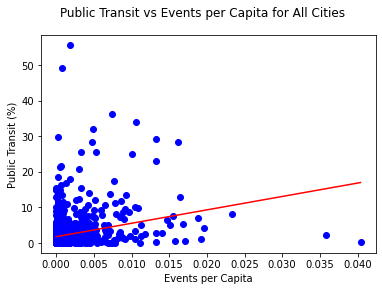

Correlation: 0.26
p-value: 1.8e-18


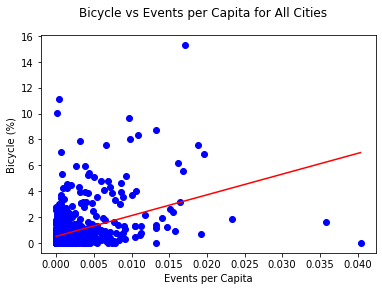

Correlation: 0.39
p-value: 5.1e-43


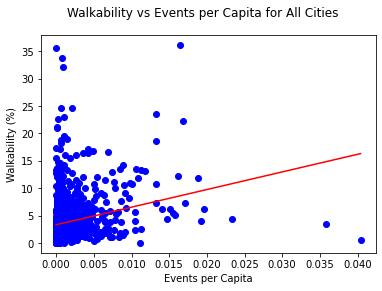

Correlation: 0.24
p-value: 7.7e-17


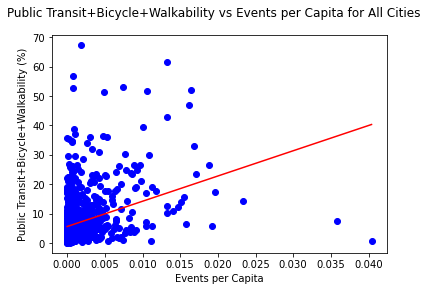

Correlation: 0.34
p-value: 1.1e-32


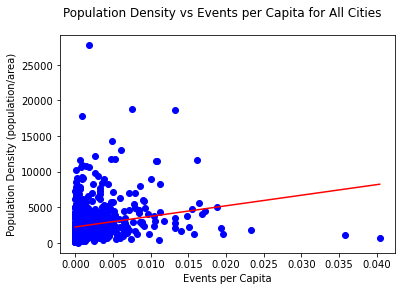

Correlation: 0.21
p-value: 1.5e-12


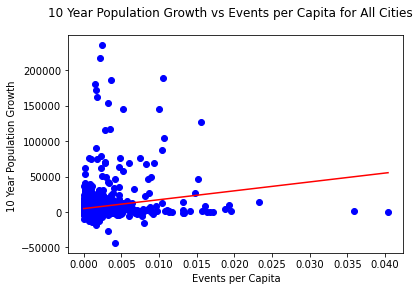

Correlation: 0.18
p-value: 9.8e-10


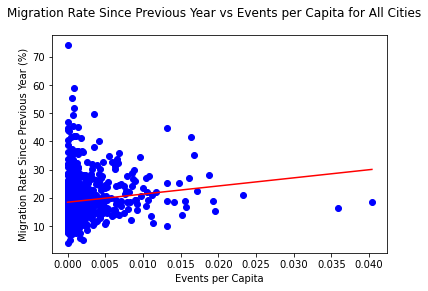

Correlation: 0.13
p-value: 1.7e-05


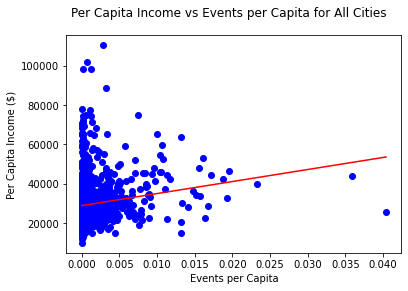

Correlation: 0.16
p-value: 3.7e-08


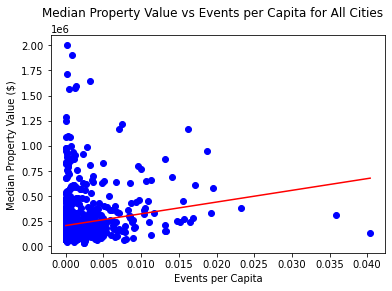

Correlation: 0.17
p-value: 1.8e-08


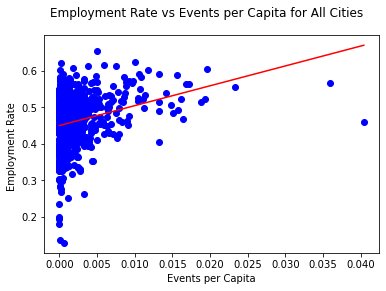

Correlation: 0.26
p-value: 4.7e-19


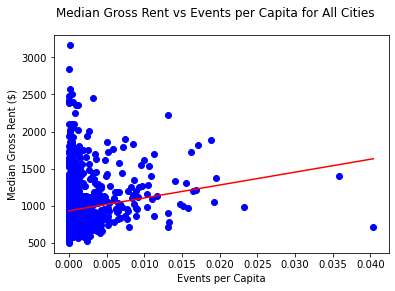

Correlation: 0.15
p-value: 2.7e-07


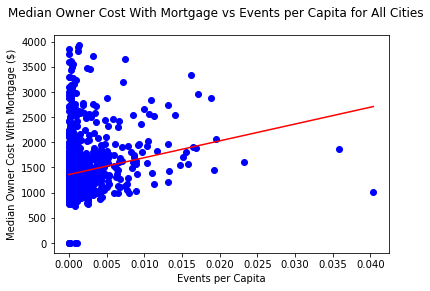

Correlation: 0.19
p-value: 2.4e-10


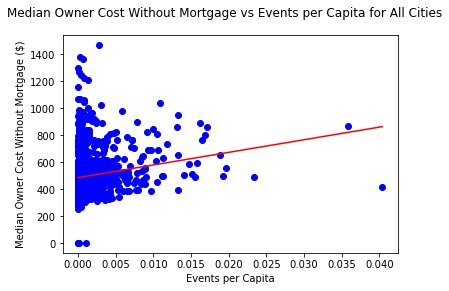

Correlation: 0.17
p-value: 2.9e-09


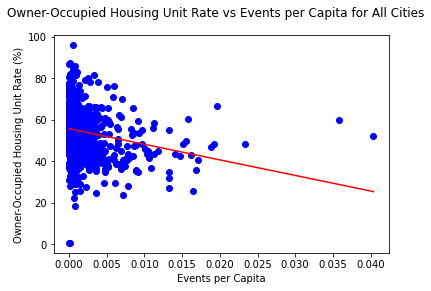

Correlation: -0.21
p-value: 3.3e-13


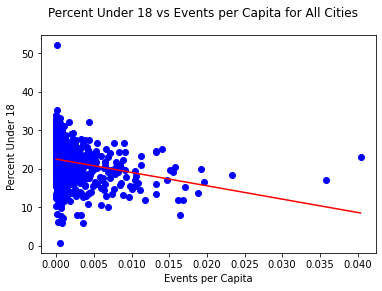

Correlation: -0.24
p-value: 7.6e-16


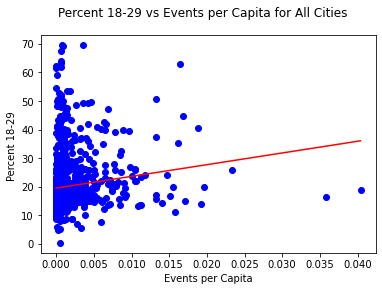

Correlation: 0.14
p-value: 1.8e-06


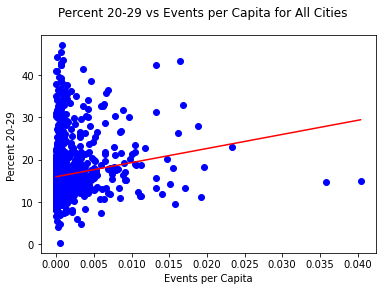

Correlation: 0.17
p-value: 2.e-08


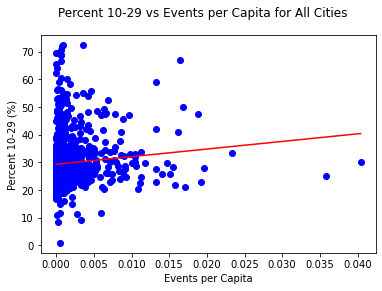

Correlation: 0.1
p-value: 4.5e-04


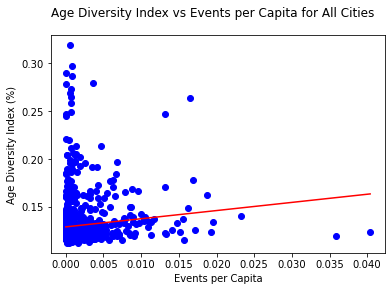

Correlation: 0.11
p-value: 1.1e-04


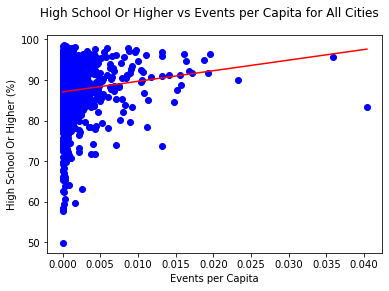

Correlation: 0.12
p-value: 6.6e-05


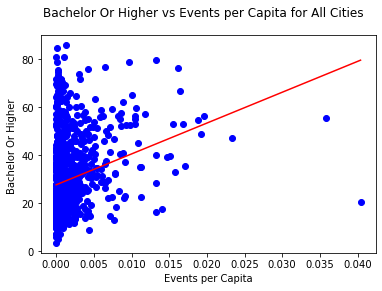

Correlation: 0.27
p-value: 6.6e-20


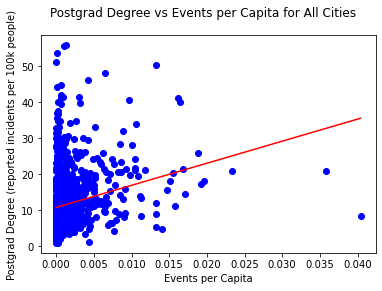

Correlation: 0.24
p-value: 8.1e-16


In [13]:
indicators_all = get_and_plot_correlations(data_combined, subset='All')

### Look at the Correlations per by category

In [14]:
# Helper function for bolding rows with significant p-values 
def df_style(val):
    return "font-weight: bold" 

In [15]:
def get_correlation_table(indicators, field):
    indicators_group = indicators[indicators['Category'] == field]
    indicators_group = indicators_group.sort_values('p-value (float)')
    indicators_group = indicators_group[indicators_group.columns.to_list()[:-2]]
    significant_indicators = pd.IndexSlice[indicators_group.index[indicators_group['p-value'].astype(float) < alpha/m], :]
    return indicators_group, indicators_group.style.applymap(df_style, subset=significant_indicators).set_caption(field)

Transportation:

In [16]:
indicators_group, indicators_group_style = get_correlation_table(indicators_all, 'Transportation')
indicators_group_style

,Indicator,r,p-value
2,Bicycle,0.390000,5.1e-43
4,Public Transit+Bicycle+Walkability,0.340000,1.1e-32
1,Public Transit,0.260000,1.8e-18
3,Walkability,0.240000,7.7e-17
0,Mean Travel Time,0.040000,1.5e-01


In [17]:
print(indicators_group.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
                         Indicator &    r & p-value \\
\midrule
                           Bicycle & 0.39 & 5.1e-43 \\
Public Transit+Bicycle+Walkability & 0.34 & 1.1e-32 \\
                    Public Transit & 0.26 & 1.8e-18 \\
                       Walkability & 0.24 & 7.7e-17 \\
                  Mean Travel Time & 0.04 & 1.5e-01 \\
\bottomrule
\end{tabular}



Population:

In [18]:
indicators_group, indicators_group_style = get_correlation_table(indicators_all, 'Population')
indicators_group_style

,Indicator,r,p-value
5,Population Density,0.210000,1.5e-12
6,10 Year Population Growth,0.180000,9.8e-10
7,Migration Rate Since Previous Year,0.130000,1.7e-05


In [19]:
print(indicators_group.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
                         Indicator &    r & p-value \\
\midrule
                Population Density & 0.21 & 1.5e-12 \\
         10 Year Population Growth & 0.18 & 9.8e-10 \\
Migration Rate Since Previous Year & 0.13 & 1.7e-05 \\
\bottomrule
\end{tabular}



Economics:

In [20]:
indicators_group, indicators_group_style = get_correlation_table(indicators_all, 'Economics')
indicators_group_style

,Indicator,r,p-value
12,Employment Rate,0.260000,4.7e-19
16,Owner-Occupied Housing Unit Rate,-0.210000,3.3e-13
14,Median Owner Cost With Mortgage,0.190000,2.4e-10
15,Median Owner Cost Without Mortgage,0.170000,2.9e-09
11,Median Property Value,0.170000,1.8e-08
8,Per Capita Income,0.160000,3.7e-08
13,Median Gross Rent,0.150000,2.7e-07
9,Median Household Income,0.060000,3.1e-02
10,Poverty Rate,-0.010000,8.2e-01


In [21]:
print(indicators_group.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
                         Indicator &     r & p-value \\
\midrule
                   Employment Rate &  0.26 & 4.7e-19 \\
  Owner-Occupied Housing Unit Rate & -0.21 & 3.3e-13 \\
   Median Owner Cost With Mortgage &  0.19 & 2.4e-10 \\
Median Owner Cost Without Mortgage &  0.17 & 2.9e-09 \\
             Median Property Value &  0.17 & 1.8e-08 \\
                 Per Capita Income &  0.16 & 3.7e-08 \\
                 Median Gross Rent &  0.15 & 2.7e-07 \\
           Median Household Income &  0.06 & 3.1e-02 \\
                      Poverty Rate & -0.01 & 8.2e-01 \\
\bottomrule
\end{tabular}



Age:

In [22]:
indicators_group, indicators_group_style = get_correlation_table(indicators_all, 'Age')
indicators_group_style

,Indicator,r,p-value
18,Percent Under 18,-0.240000,7.6e-16
21,Percent 20-29,0.170000,2.e-08
19,Percent 18-29,0.140000,1.8e-06
23,Age Diversity Index,0.110000,1.1e-04
22,Percent 10-29,0.100000,4.5e-04
17,Median Age,-0.060000,4.1e-02
20,Percent Under 30,0.020000,4.1e-01


In [23]:
print(indicators_group.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
          Indicator &     r & p-value \\
\midrule
   Percent Under 18 & -0.24 & 7.6e-16 \\
      Percent 20-29 &  0.17 &  2.e-08 \\
      Percent 18-29 &  0.14 & 1.8e-06 \\
Age Diversity Index &  0.11 & 1.1e-04 \\
      Percent 10-29 &  0.10 & 4.5e-04 \\
         Median Age & -0.06 & 4.1e-02 \\
   Percent Under 30 &  0.02 & 4.1e-01 \\
\bottomrule
\end{tabular}



Education, Race, and Crime:

In [24]:
indicators_group, indicators_group_style = get_correlation_table(indicators_all, 'Education')
indicators_group_style

,Indicator,r,p-value
25,Bachelor Or Higher,0.270000,6.6e-20
26,Postgrad Degree,0.240000,8.1e-16
24,High School Or Higher,0.120000,6.6e-05
27,Race Diversity Index,-0.070000,1.9e-02


In [25]:
print(indicators_group.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
            Indicator &     r & p-value \\
\midrule
   Bachelor Or Higher &  0.27 & 6.6e-20 \\
      Postgrad Degree &  0.24 & 8.1e-16 \\
High School Or Higher &  0.12 & 6.6e-05 \\
 Race Diversity Index & -0.07 & 1.9e-02 \\
\bottomrule
\end{tabular}



## SMALL CITIES (10K - 100K population)

In [26]:
data_combined_small = data_combined[(data_combined['Population'] <= 100000)]

### Top 3 Music Deserts for small cities:
Notice that the more than 3 cities have zero events per capita. We only sampled the top 3 of them with the largest population.

In [27]:
# Rank by population (descending)
# data_combined_small[['Principal City Name', 'State', 'Latitude', 'Longitude', 'Population', 'Number of Events', 'Live Event Music Rate (LMER)']][data_combined['Number of Events'] == 0].sort_values('Population').iloc[::-1].head(3)

deserts_small = data_combined_small[['Principal City Name', 'State', 'Number of Events', 'Population', 'Live Event Music Rate (LMER)']][data_combined['Number of Events'] == 0].sort_values('Population').iloc[::-1].head(3)
deserts_small

<ipython-input-27-1cd45a2a9d7a>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  deserts_small = data_combined_small[['Principal City Name', 'State', 'Number of Events', 'Population', 'Live Event Music Rate (LMER)']][data_combined['Number of Events'] == 0].sort_values('Population').iloc[::-1].head(3)


,Principal City Name,State,Number of Events,Population,Live Event Music Rate (LMER)
1064,Deltona,FL,0,92752,0.0
1094,Newton,MA,0,88411,0.0
1057,Milpitas,CA,0,84184,0.0


In [28]:
print(deserts_small.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
Principal City Name & State &  Number of Events &  Population &  Live Event Music Rate (LMER) \\
\midrule
            Deltona &    FL &                 0 &       92752 &                           0.0 \\
             Newton &    MA &                 0 &       88411 &                           0.0 \\
           Milpitas &    CA &                 0 &       84184 &                           0.0 \\
\bottomrule
\end{tabular}



### Top 10 Music Havens for small cities:

In [29]:
havens_small = data_combined_small[['Principal City Name', 'State',  'Number of Events', 'Population', 'Live Event Music Rate (LMER)']].iloc[1:11]
havens_small
# ignore Manchester, since all the events are associated with Bonaroo Festival, which happens once annually. 

,Principal City Name,State,Number of Events,Population,Live Event Music Rate (LMER)
1,South Burlington,VT,687,19162,0.035852
3,Steamboat Springs,CO,253,12928,0.019570
4,Asheville,NC,1790,92859,0.019277
5,Santa Cruz,CA,1214,64605,0.018791
6,Key West,FL,426,24843,0.017148
7,Burlington,VT,716,42545,0.016829
8,Ithaca,NY,502,30569,0.016422
10,Fredericksburg,TX,177,11245,0.015740
14,Lahaina,HI,180,12776,0.014089
15,Rutland,VT,204,15398,0.013248


In [30]:
print(havens_small.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
Principal City Name & State &  Number of Events &  Population &  Live Event Music Rate (LMER) \\
\midrule
   South Burlington &    VT &               687 &       19162 &                      0.035852 \\
  Steamboat Springs &    CO &               253 &       12928 &                      0.019570 \\
          Asheville &    NC &              1790 &       92859 &                      0.019277 \\
         Santa Cruz &    CA &              1214 &       64605 &                      0.018791 \\
           Key West &    FL &               426 &       24843 &                      0.017148 \\
         Burlington &    VT &               716 &       42545 &                      0.016829 \\
             Ithaca &    NY &               502 &       30569 &                      0.016422 \\
     Fredericksburg &    TX &               177 &       11245 &                      0.015740 \\
            Lahaina &    HI &               180 &       12776 &                      0

### Statistical Tests with Bonferroni Corrections
Since there are so many features we want to sample, we need to use Bonferroni corrections on the features we use. 

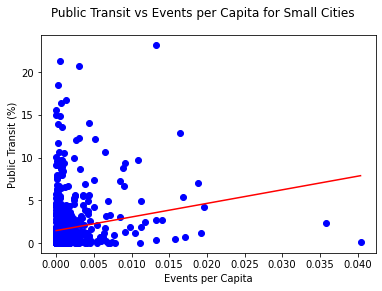

Correlation: 0.17
p-value: 3.3e-07


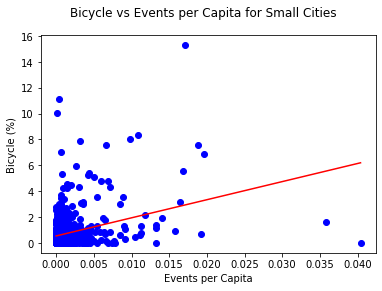

Correlation: 0.33
p-value: 7.9e-25


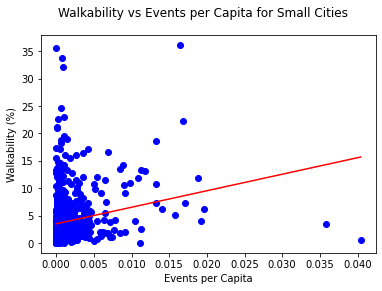

Correlation: 0.21
p-value: 1.4e-10


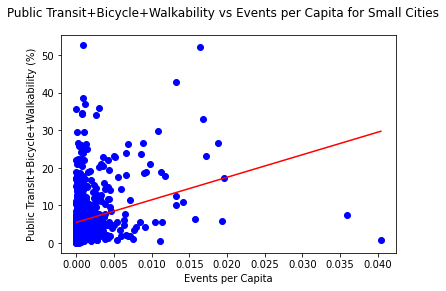

Correlation: 0.27
p-value: 4.e-17


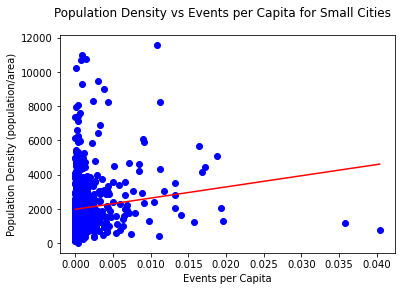

Correlation: 0.13
p-value: 1.2e-04


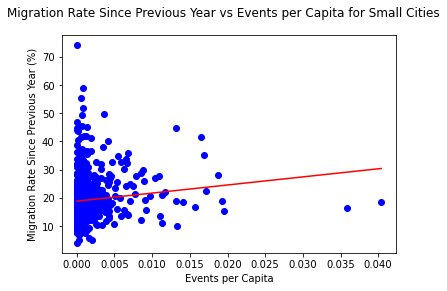

Correlation: 0.12
p-value: 4.8e-04


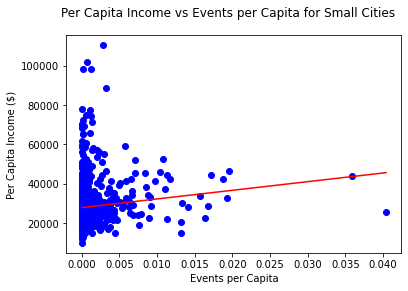

Correlation: 0.12
p-value: 4.4e-04


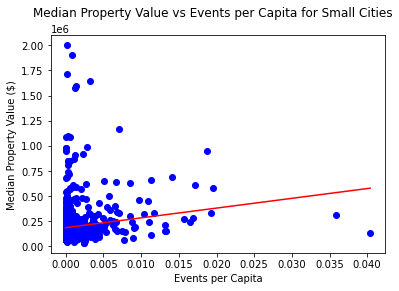

Correlation: 0.14
p-value: 1.3e-05


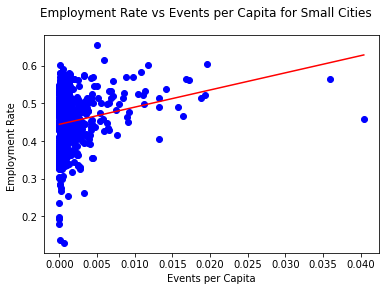

Correlation: 0.21
p-value: 3.2e-10


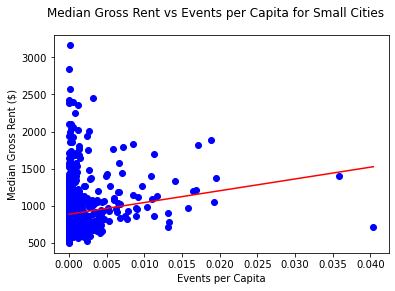

Correlation: 0.14
p-value: 1.7e-05


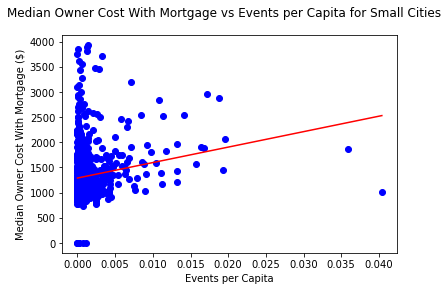

Correlation: 0.18
p-value: 7.1e-08


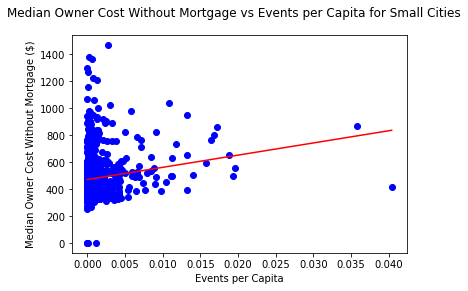

Correlation: 0.16
p-value: 6.9e-07


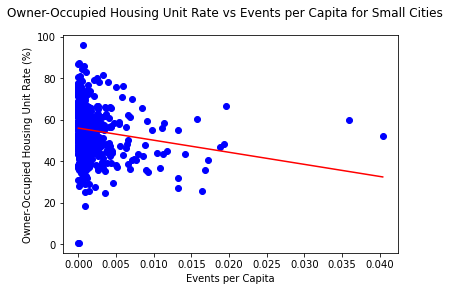

Correlation: -0.16
p-value: 1.9e-06


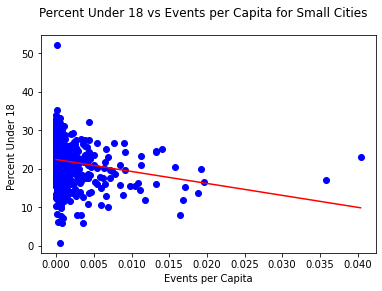

Correlation: -0.19
p-value: 3.8e-09


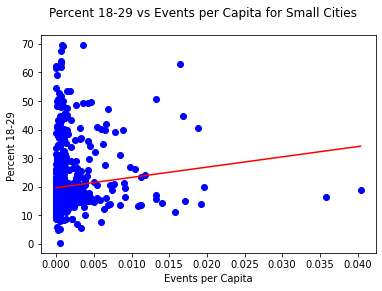

Correlation: 0.11
p-value: 8.2e-04


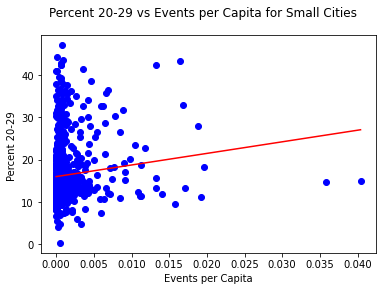

Correlation: 0.12
p-value: 1.9e-04


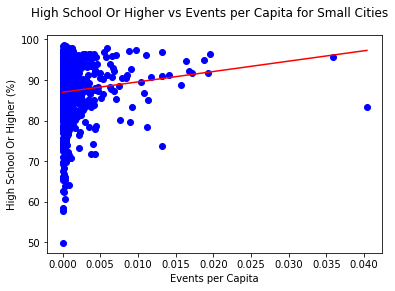

Correlation: 0.11
p-value: 9.6e-04


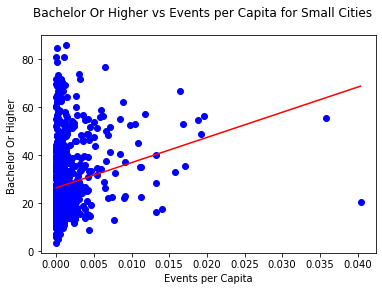

Correlation: 0.22
p-value: 4.7e-11


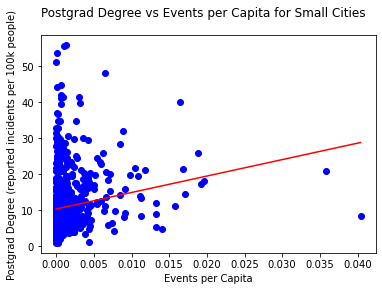

Correlation: 0.17
p-value: 1.4e-07


In [31]:
indicators_small = get_and_plot_correlations(data_combined_small, subset='Small')

### Look at the Correlations per by category

Transportation:

In [32]:
indicators_group, indicators_group_style = get_correlation_table(indicators_small, 'Transportation')
indicators_group_style

,Indicator,r,p-value
2,Bicycle,0.330000,7.9e-25
4,Public Transit+Bicycle+Walkability,0.270000,4.e-17
3,Walkability,0.210000,1.4e-10
1,Public Transit,0.170000,3.3e-07
0,Mean Travel Time,-0.030000,3.6e-01


Population:

In [33]:
indicators_group, indicators_group_style = get_correlation_table(indicators_small, 'Population')
indicators_group_style

,Indicator,r,p-value
5,Population Density,0.130000,1.2e-04
7,Migration Rate Since Previous Year,0.120000,4.8e-04
6,10 Year Population Growth,0.060000,6.1e-02


Economics:

In [34]:
indicators_group, indicators_group_style = get_correlation_table(indicators_small, 'Economics')
indicators_group_style

,Indicator,r,p-value
12,Employment Rate,0.210000,3.2e-10
14,Median Owner Cost With Mortgage,0.180000,7.1e-08
15,Median Owner Cost Without Mortgage,0.160000,6.9e-07
16,Owner-Occupied Housing Unit Rate,-0.160000,1.9e-06
11,Median Property Value,0.140000,1.3e-05
13,Median Gross Rent,0.140000,1.7e-05
8,Per Capita Income,0.120000,4.4e-04
9,Median Household Income,0.050000,1.7e-01
10,Poverty Rate,-0.020000,6.2e-01


Age:

In [35]:
indicators_group, indicators_group_style = get_correlation_table(indicators_small, 'Age')
indicators_group_style

,Indicator,r,p-value
18,Percent Under 18,-0.190000,3.8e-09
21,Percent 20-29,0.120000,1.9e-04
19,Percent 18-29,0.110000,8.2e-04
23,Age Diversity Index,0.100000,1.8e-03
22,Percent 10-29,0.090000,9.1e-03
17,Median Age,-0.030000,4.3e-01
20,Percent Under 30,0.020000,6.0e-01


Education, Race, and Crime:

In [36]:
indicators_group, indicators_group_style = get_correlation_table(indicators_small, 'Education')
indicators_group_style

,Indicator,r,p-value
25,Bachelor Or Higher,0.220000,4.7e-11
26,Postgrad Degree,0.170000,1.4e-07
24,High School Or Higher,0.110000,9.6e-04
27,Race Diversity Index,-0.000000,9.6e-01


## MEDIUM CITIES (100K - 500K population)

In [37]:
data_combined_medium = data_combined[(data_combined['Population'] > 100000) & (data_combined['Population'] < 500000)]

### Top 3 Music Deserts for medium cities:

In [38]:
# Rank by population (descending)
medium_deserts = data_combined_medium[['Principal City Name', 'State',  'Number of Events', 'Population', 'Live Event Music Rate (LMER)']].sort_values('Live Event Music Rate (LMER)').head(3)
medium_deserts

,Principal City Name,State,Number of Events,Population,Live Event Music Rate (LMER)
1089,Renton,WA,0,101747,0.000000
1051,Paradise,NV,1,237899,0.000004
1050,Corona,CA,2,169854,0.000012


In [39]:
print(medium_deserts.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
Principal City Name & State &  Number of Events &  Population &  Live Event Music Rate (LMER) \\
\midrule
             Renton &    WA &                 0 &      101747 &                      0.000000 \\
           Paradise &    NV &                 1 &      237899 &                      0.000004 \\
             Corona &    CA &                 2 &      169854 &                      0.000012 \\
\bottomrule
\end{tabular}



### Top 10 Music Havens for medium cities:

In [40]:
# Rank by population (descending)
medium_havens = data_combined_medium[['Principal City Name', 'State', 'Number of Events', 'Population', 'Live Event Music Rate (LMER)']].head(10)
medium_havens

,Principal City Name,State,Number of Events,Population,Live Event Music Rate (LMER)
2,Salt Lake City,UT,4670,200546,0.023286
9,Berkeley,CA,1960,121353,0.016151
12,New Orleans,LA,5904,390144,0.015133
13,Richmond,VA,3401,230436,0.014759
18,Cambridge,MA,1569,118925,0.013193
30,Boulder,CO,1016,105670,0.009615
35,Orlando,FL,2557,287435,0.008896
37,Fort Collins,CO,1472,170245,0.008646
38,Minneapolis,MN,3685,429605,0.008578
42,Charleston,SC,1174,143151,0.008201


In [41]:
print(medium_havens.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
Principal City Name & State &  Number of Events &  Population &  Live Event Music Rate (LMER) \\
\midrule
     Salt Lake City &    UT &              4670 &      200546 &                      0.023286 \\
           Berkeley &    CA &              1960 &      121353 &                      0.016151 \\
        New Orleans &    LA &              5904 &      390144 &                      0.015133 \\
           Richmond &    VA &              3401 &      230436 &                      0.014759 \\
          Cambridge &    MA &              1569 &      118925 &                      0.013193 \\
            Boulder &    CO &              1016 &      105670 &                      0.009615 \\
            Orlando &    FL &              2557 &      287435 &                      0.008896 \\
       Fort Collins &    CO &              1472 &      170245 &                      0.008646 \\
        Minneapolis &    MN &              3685 &      429605 &                      0

### Statistical Tests with Bonferroni Corrections
Since there are so many features we want to sample, we need to use Bonferroni corrections on the features we use. 

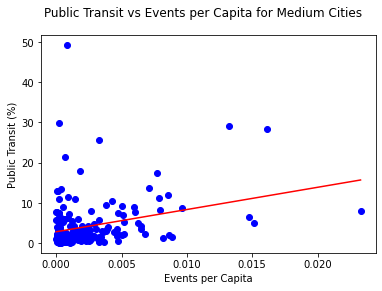

Correlation: 0.29
p-value: 2.9e-05


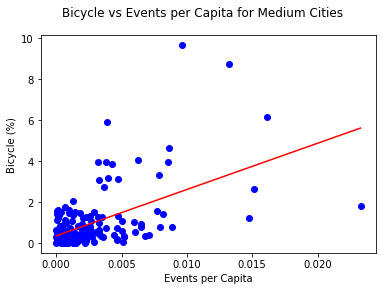

Correlation: 0.54
p-value: 9.6e-17


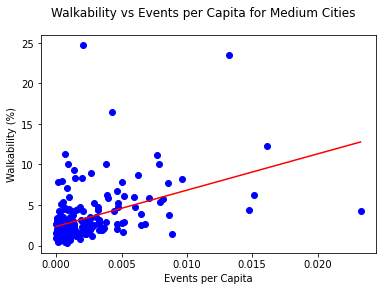

Correlation: 0.43
p-value: 2.4e-10


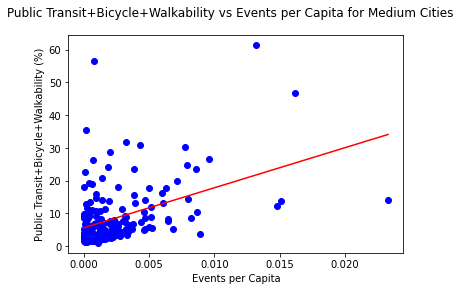

Correlation: 0.44
p-value: 1.2e-10


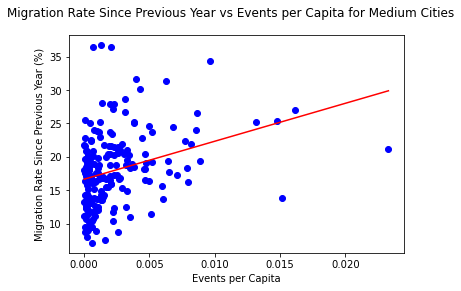

Correlation: 0.32
p-value: 4.e-06


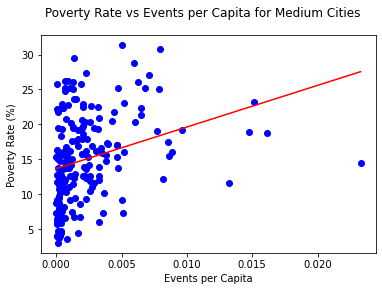

Correlation: 0.3
p-value: 2.2e-05


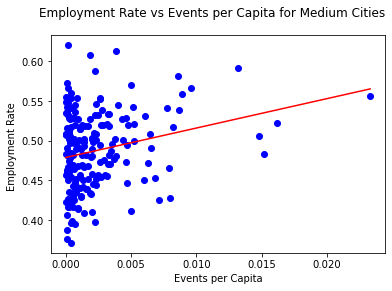

Correlation: 0.24
p-value: 5.6e-04


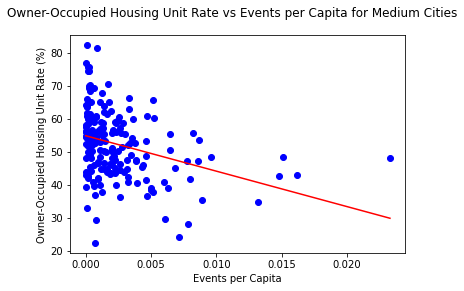

Correlation: -0.33
p-value: 1.5e-06


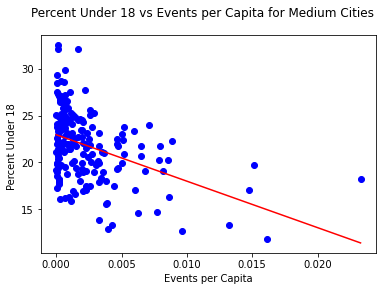

Correlation: -0.42
p-value: 5.7e-10


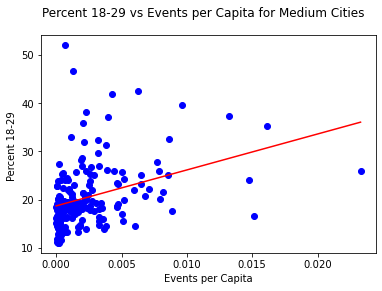

Correlation: 0.36
p-value: 1.3e-07


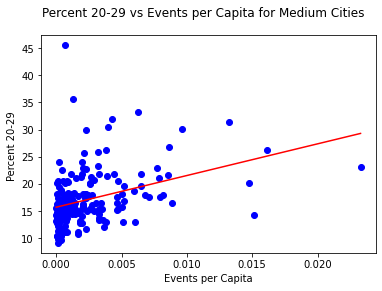

Correlation: 0.37
p-value: 6.6e-08


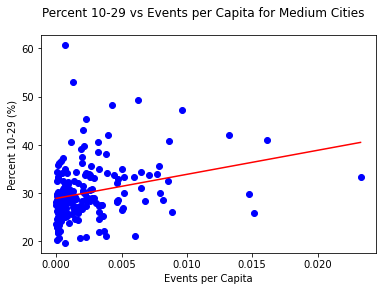

Correlation: 0.27
p-value: 1.4e-04


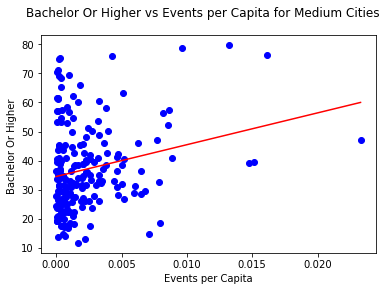

Correlation: 0.23
p-value: 1.1e-03


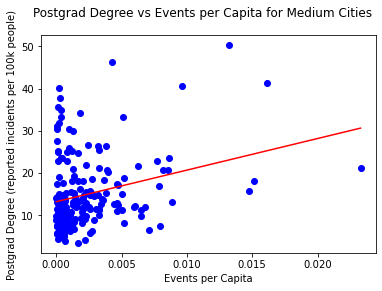

Correlation: 0.28
p-value: 7.1e-05


In [42]:
indicators_medium = get_and_plot_correlations(data_combined_medium, subset='Medium')

### Look at the Correlations per by category

Transportation:

In [43]:
indicators_group, indicators_group_style = get_correlation_table(indicators_medium, 'Transportation')
indicators_group_style

,Indicator,r,p-value
2,Bicycle,0.540000,9.6e-17
4,Public Transit+Bicycle+Walkability,0.440000,1.2e-10
3,Walkability,0.430000,2.4e-10
1,Public Transit,0.290000,2.9e-05
0,Mean Travel Time,-0.100000,1.5e-01


Population:

In [44]:
indicators_group, indicators_group_style = get_correlation_table(indicators_medium, 'Population')
indicators_group_style

,Indicator,r,p-value
7,Migration Rate Since Previous Year,0.320000,4.e-06
5,Population Density,0.180000,9.4e-03
6,10 Year Population Growth,0.060000,3.7e-01


Economics:

In [45]:
indicators_group, indicators_group_style = get_correlation_table(indicators_medium, 'Economics')
indicators_group_style

,Indicator,r,p-value
16,Owner-Occupied Housing Unit Rate,-0.330000,1.5e-06
10,Poverty Rate,0.300000,2.2e-05
12,Employment Rate,0.240000,5.6e-04
9,Median Household Income,-0.130000,6.3e-02
13,Median Gross Rent,-0.070000,3.4e-01
8,Per Capita Income,0.040000,5.5e-01
14,Median Owner Cost With Mortgage,-0.030000,6.8e-01
15,Median Owner Cost Without Mortgage,0.030000,6.9e-01
11,Median Property Value,0.030000,7.2e-01


Age:

In [46]:
indicators_group, indicators_group_style = get_correlation_table(indicators_medium, 'Age')
indicators_group_style

,Indicator,r,p-value
18,Percent Under 18,-0.420000,5.7e-10
21,Percent 20-29,0.370000,6.6e-08
19,Percent 18-29,0.360000,1.3e-07
22,Percent 10-29,0.270000,1.4e-04
23,Age Diversity Index,0.220000,1.8e-03
17,Median Age,-0.180000,1.0e-02
20,Percent Under 30,0.130000,6.2e-02


Education, Race, and Crime:

In [47]:
indicators_group, indicators_group_style = get_correlation_table(indicators_medium, 'Education')
indicators_group_style

,Indicator,r,p-value
26,Postgrad Degree,0.280000,7.1e-05
25,Bachelor Or Higher,0.230000,1.1e-03
24,High School Or Higher,0.100000,1.5e-01
27,Race Diversity Index,0.020000,8.3e-01


## LARGE CITIES (500K or larger population)

In [48]:
data_combined_large = data_combined[(data_combined['Population'] >= 500000)]

### Top 3 Music Deserts for large cities:

In [49]:
# Rank by population (descending)
deserts_large = data_combined_large[['Principal City Name', 'State', 'Number of Events', 'Population', 'Live Event Music Rate (LMER)']].iloc[::-1].head(3)
deserts_large

,Principal City Name,State,Number of Events,Population,Live Event Music Rate (LMER)
492,San Jose,CA,714,1021786,0.000699
408,El Paso,TX,657,681729,0.000964
365,Fresno,CA,602,531581,0.001132


In [50]:
print(deserts_large.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
Principal City Name & State &  Number of Events &  Population &  Live Event Music Rate (LMER) \\
\midrule
           San Jose &    CA &               714 &     1021786 &                      0.000699 \\
            El Paso &    TX &               657 &      681729 &                      0.000964 \\
             Fresno &    CA &               602 &      531581 &                      0.001132 \\
\bottomrule
\end{tabular}



### Top 10 Music Havens for large cities:

In [51]:
havens_large = data_combined_large[['Principal City Name', 'State', 'Number of Events', 'Population',  'Live Event Music Rate (LMER)']].head(10)
havens_large

,Principal City Name,State,Number of Events,Population,Live Event Music Rate (LMER)
11,Denver,CO,11300,727211,0.015539
24,Washington,DC,7519,705749,0.010654
25,Austin,TX,10308,979263,0.010526
27,Atlanta,GA,5272,506804,0.010402
28,Seattle,WA,7541,753655,0.010006
31,Portland,OR,6059,653467,0.009272
41,Las Vegas,NV,5427,651297,0.008333
48,San Francisco,CA,6581,881549,0.007465
73,Philadelphia,PA,8356,1584064,0.005275
74,Dallas,TX,7053,1343565,0.005249


In [52]:
print(havens_large.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
Principal City Name & State &  Number of Events &  Population &  Live Event Music Rate (LMER) \\
\midrule
             Denver &    CO &             11300 &      727211 &                      0.015539 \\
         Washington &    DC &              7519 &      705749 &                      0.010654 \\
             Austin &    TX &             10308 &      979263 &                      0.010526 \\
            Atlanta &    GA &              5272 &      506804 &                      0.010402 \\
            Seattle &    WA &              7541 &      753655 &                      0.010006 \\
           Portland &    OR &              6059 &      653467 &                      0.009272 \\
          Las Vegas &    NV &              5427 &      651297 &                      0.008333 \\
      San Francisco &    CA &              6581 &      881549 &                      0.007465 \\
       Philadelphia &    PA &              8356 &     1584064 &                      0

### Statistical Tests with Bonferroni Corrections
Since there are so many features we want to sample, we need to use Bonferroni corrections on the features we use. 

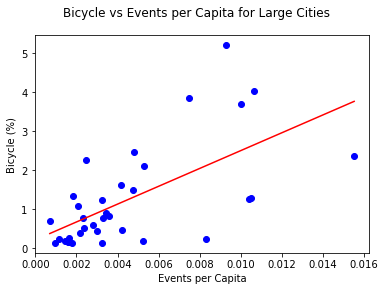

Correlation: 0.63
p-value: 4.3e-05


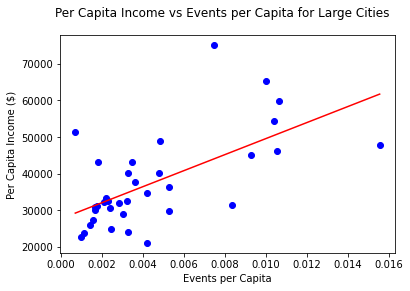

Correlation: 0.62
p-value: 6.6e-05


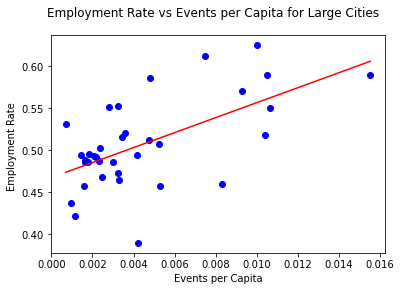

Correlation: 0.6
p-value: 1.5e-04


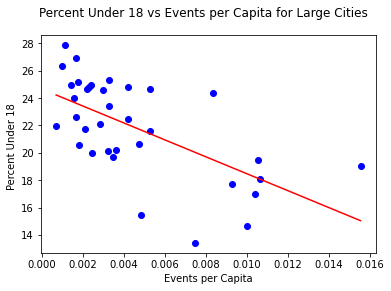

Correlation: -0.62
p-value: 6.7e-05


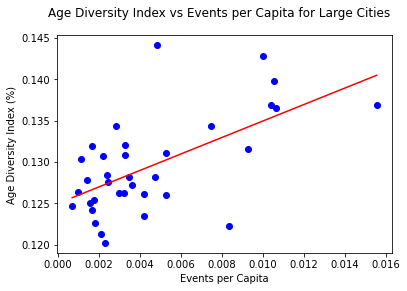

Correlation: 0.61
p-value: 1.2e-04


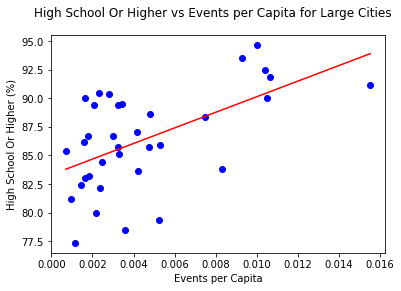

Correlation: 0.56
p-value: 4.9e-04


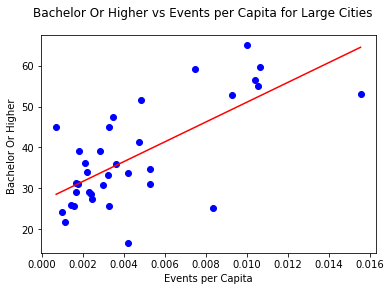

Correlation: 0.69
p-value: 3.7e-06


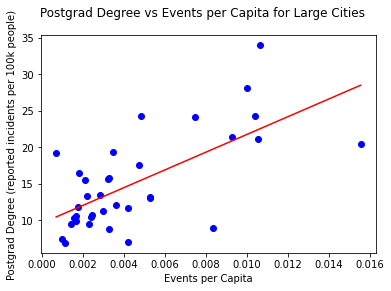

Correlation: 0.67
p-value: 1.1e-05


In [53]:
indicators_large = get_and_plot_correlations(data_combined_large, subset='Large')

### Look at the Correlations per by category

Transportation:

In [54]:
indicators_group, indicators_group_style = get_correlation_table(indicators_large, 'Transportation')
indicators_group_style

,Indicator,r,p-value
2,Bicycle,0.630000,4.3e-05
3,Walkability,0.440000,7.7e-03
4,Public Transit+Bicycle+Walkability,0.360000,3.5e-02
1,Public Transit,0.280000,9.9e-02
0,Mean Travel Time,0.170000,3.4e-01


Population:

In [55]:
indicators_group, indicators_group_style = get_correlation_table(indicators_large, 'Population')
indicators_group_style

,Indicator,r,p-value
7,Migration Rate Since Previous Year,0.450000,6.1e-03
5,Population Density,0.150000,4.e-01
6,10 Year Population Growth,0.120000,4.9e-01


Economics:

In [56]:
indicators_group, indicators_group_style = get_correlation_table(indicators_large, 'Economics')
indicators_group_style

,Indicator,r,p-value
8,Per Capita Income,0.620000,6.6e-05
12,Employment Rate,0.600000,1.5e-04
9,Median Household Income,0.400000,1.7e-02
15,Median Owner Cost Without Mortgage,0.330000,5.6e-02
11,Median Property Value,0.320000,6.e-02
13,Median Gross Rent,0.310000,6.6e-02
14,Median Owner Cost With Mortgage,0.310000,7.4e-02
16,Owner-Occupied Housing Unit Rate,-0.270000,1.2e-01
10,Poverty Rate,-0.250000,1.5e-01


Age:

In [57]:
indicators_group, indicators_group_style = get_correlation_table(indicators_large, 'Age')
indicators_group_style

,Indicator,r,p-value
18,Percent Under 18,-0.620000,6.7e-05
23,Age Diversity Index,0.610000,1.2e-04
20,Percent Under 30,-0.420000,1.2e-02
21,Percent 20-29,0.400000,1.8e-02
19,Percent 18-29,0.320000,6.0e-02
22,Percent 10-29,-0.140000,4.2e-01
17,Median Age,0.100000,5.8e-01


Education, Race, & Crime

In [58]:
indicators_group, indicators_group_style = get_correlation_table(indicators_large, 'Education')
indicators_group_style

,Indicator,r,p-value
25,Bachelor Or Higher,0.690000,3.7e-06
26,Postgrad Degree,0.670000,1.1e-05
24,High School Or Higher,0.560000,4.9e-04
27,Race Diversity Index,-0.010000,9.3e-01


## A Composite Table of All R-Values and P-Values (for every city size category)


In [59]:
# RUN THIS ONLY ONCE!!!!
indicators_all = indicators_all[indicators_all.columns.to_list()[:-2]]
indicators_small = indicators_small[indicators_small.columns.to_list()[:-2]]
indicators_medium = indicators_medium[indicators_medium.columns.to_list()[:-2]]
indicators_large = indicators_large[indicators_large.columns.to_list()[:-2]]

In [60]:
def composite_table(indicators_all, indicators_small, indicators_medium, indicators_large, verbose=False):
        
    if verbose:
        indicators_all['significant?'] = indicators_all['p-value'].astype(float) < alpha/m
        indicators_small['significant?'] = indicators_small['p-value'].astype(float) < alpha/m
        indicators_medium['significant?'] = indicators_medium['p-value'].astype(float) < alpha/m
        indicators_large['significant?'] = indicators_large['p-value'].astype(float) < alpha/m
    
    cols = ['r', 'p-value', 'significant?'] if verbose else ['r', 'p-value']
    
    indicators = pd.concat([indicators_all[cols], indicators_small[cols], indicators_medium[cols], indicators_large[cols]], axis=1)
    
    df_multiindex = pd.MultiIndex.from_product(
        (('All Cities', 'Small Cities', 'Medium Cities', 'Large Cities'), 
         (('r', 'p-value') if not verbose else ('r', 'p-value', 'significant?')))
    )    
    
    indicators.columns = df_multiindex
    
    # "Indicator" column to front 
    indicators['Indicator'] = indicators_all['Indicator']
    col = indicators.pop('Indicator')
    indicators.insert(0, col.name, col)

    index_groups = ['Transportation'] + [''] * 4 + ['Population'] + [''] * 2 + ['Economics'] + [''] * 8 + ['Age'] + [''] * 6 + ['Education'] + [''] * 3 
    indicators['Category'] = index_groups
    
    return indicators

In [61]:
indicators = composite_table(indicators_all, indicators_small, indicators_medium, indicators_large).set_index('Category')
indicators

Indicator All Cities           \
                                                            r  p-value   
Category                                                                 
Transportation                    Mean Travel Time       0.04  1.5e-01   
                                    Public Transit       0.26  1.8e-18   
                                           Bicycle       0.39  5.1e-43   
                                       Walkability       0.24  7.7e-17   
                Public Transit+Bicycle+Walkability       0.34  1.1e-32   
Population                      Population Density       0.21  1.5e-12   
                         10 Year Population Growth       0.18  9.8e-10   
                Migration Rate Since Previous Year       0.13  1.7e-05   
Economics                        Per Capita Income       0.16  3.7e-08   
                           Median Household Income       0.06  3.1e-02   
                                      Poverty Rate      -0.01  8.2e-01   
                             Median Property Value       0.17  1.8e-08   
                                   Employment Rate       0.26  4.7e-19   
                                 Median Gross Rent       0.15  2.7e-07   
                   Median Owner Cost With Mortgage       0.19  2.4e-10   
                Median Owner Cost Without Mortgage       0.17  2.9e-09   
                  Owner-Occupied Housing Unit Rate      -0.21  3.3e-13   
Age                                     Median Age      -0.06  4.1e-02   
                                  Percent Under 18      -0.24  7.6e-16   
                                     Percent 18-29       0.14  1.8e-06   
                                  Percent Under 30       0.02  4.1e-01   
                                     Percent 20-29       0.17   2.e-08   
                                     Percent 10-29       0.10  4.5e-04   
                               Age Diversity Index       0.11  1.1e-04   
Education                    High School Or Higher       0.12  6.6e-05   
                                Bachelor Or Higher       0.27  6.6e-20   
                                   Postgrad Degree       0.24  8.1e-16   
                              Race Diversity Index      -0.07  1.9e-02   

               Small Cities          Medium Cities          Large Cities  \
                          r  p-value             r  p-value            r   
Category                                                                   
Transportation        -0.03  3.6e-01         -0.10  1.5e-01         0.17   
                       0.17  3.3e-07          0.29  2.9e-05         0.28   
                       0.33  7.9e-25          0.54  9.6e-17         0.63   
                       0.21  1.4e-10          0.43  2.4e-10         0.44   
                       0.27   4.e-17          0.44  1.2e-10         0.36   
Population             0.13  1.2e-04          0.18  9.4e-03         0.15   
                       0.06  6.1e-02          0.06  3.7e-01         0.12   
                       0.12  4.8e-04          0.32   4.e-06         0.45   
Economics              0.12  4.4e-04          0.04  5.5e-01         0.62   
                       0.05  1.7e-01         -0.13  6.3e-02         0.40   
                      -0.02  6.2e-01          0.30  2.2e-05        -0.25   
                       0.14  1.3e-05          0.03  7.2e-01         0.32   
                       0.21  3.2e-10          0.24  5.6e-04         0.60   
                       0.14  1.7e-05         -0.07  3.4e-01         0.31   
                       0.18  7.1e-08         -0.03  6.8e-01         0.31   
                       0.16  6.9e-07          0.03  6.9e-01         0.33   
                      -0.16  1.9e-06         -0.33  1.5e-06        -0.27   
Age                   -0.03  4.3e-01         -0.18  1.0e-02         0.10   
                      -0.19  3.8e-09         -0.42  5.7e-10        -0.62   
                       0.11  8.2e-04          0.36  1.3e-07         0.32  

In [62]:
# Convert to latex (for paper). 
# TODO (in paper): Make sure to bold the statistically significant entries!
print(indicators.to_latex())

\begin{tabular}{llrlrlrlrl}
\toprule
{} &                           Indicator & \multicolumn{2}{l}{All Cities} & \multicolumn{2}{l}{Small Cities} & \multicolumn{2}{l}{Medium Cities} & \multicolumn{2}{l}{Large Cities} \\
{} &          r &  p-value &            r &  p-value &             r &  p-value &            r &  p-value \\
Category       &                                     &            &          &              &          &               &          &              &          \\
\midrule
Transportation &                    Mean Travel Time &       0.04 &  1.5e-01 &        -0.03 &  3.6e-01 &         -0.10 &  1.5e-01 &         0.17 &  3.4e-01 \\
               &                      Public Transit &       0.26 &  1.8e-18 &         0.17 &  3.3e-07 &          0.29 &  2.9e-05 &         0.28 &  9.9e-02 \\
               &                             Bicycle &       0.39 &  5.1e-43 &         0.33 &  7.9e-25 &          0.54 &  9.6e-17 &         0.63 &  4.3e-05 \\
               &          

In [63]:
# For paper-aiding only:
print('p-value must be under:', precision_round_sn(alpha/m))

composite_table(indicators_all, indicators_small, indicators_medium, indicators_large, verbose=True).set_index('Category')

p-value must be under: 1.786e-03


Indicator All Cities           \
                                                            r  p-value   
Category                                                                 
Transportation                    Mean Travel Time       0.04  1.5e-01   
                                    Public Transit       0.26  1.8e-18   
                                           Bicycle       0.39  5.1e-43   
                                       Walkability       0.24  7.7e-17   
                Public Transit+Bicycle+Walkability       0.34  1.1e-32   
Population                      Population Density       0.21  1.5e-12   
                         10 Year Population Growth       0.18  9.8e-10   
                Migration Rate Since Previous Year       0.13  1.7e-05   
Economics                        Per Capita Income       0.16  3.7e-08   
                           Median Household Income       0.06  3.1e-02   
                                      Poverty Rate      -0.01  8.2e-01   
                             Median Property Value       0.17  1.8e-08   
                                   Employment Rate       0.26  4.7e-19   
                                 Median Gross Rent       0.15  2.7e-07   
                   Median Owner Cost With Mortgage       0.19  2.4e-10   
                Median Owner Cost Without Mortgage       0.17  2.9e-09   
                  Owner-Occupied Housing Unit Rate      -0.21  3.3e-13   
Age                                     Median Age      -0.06  4.1e-02   
                                  Percent Under 18      -0.24  7.6e-16   
                                     Percent 18-29       0.14  1.8e-06   
                                  Percent Under 30       0.02  4.1e-01   
                                     Percent 20-29       0.17   2.e-08   
                                     Percent 10-29       0.10  4.5e-04   
                               Age Diversity Index       0.11  1.1e-04   
Education                    High School Or Higher       0.12  6.6e-05   
                                Bachelor Or Higher       0.27  6.6e-20   
                                   Postgrad Degree       0.24  8.1e-16   
                              Race Diversity Index      -0.07  1.9e-02   

                            Small Cities                       Medium Cities  \
               significant?            r  p-value significant?             r   
Category                                                                       
Transportation        False        -0.03  3.6e-01        False         -0.10   
                       True         0.17  3.3e-07         True          0.29   
                       True         0.33  7.9e-25         True          0.54   
                       True         0.21  1.4e-10         True          0.43   
                       True         0.27   4.e-17         True          0.44   
Population             True         0.13  1.2e-04         True          0.18   
                       True         0.06  6.1e-02        False          0.06   
                       True         0.12  4.8e-04         True          0.32   
Economics              True         0.12  4.4e-04         True          0.04   
                      False         0.05  1.7e-01        False         -0.13   
                      False        -0.02  6.2e-01        False          0.30   
                       True         0.14  1.3e-05         True          0.03   
                       True         0.21  3.2e-10         True          0.24   
                       True         0.14  1.7e-05         True         -0.07   
                       True         0.18  7.1e-08         True         -0.03   
                       True         0.16  6.9e-07         True          0.03   
                       True        -0.16  1.9e-06         True         -0.33   
Age                   False        -0.03  4.3e-01        False         -0.18   
                       True        -0.19  3.8e-09         True    